In [100]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [101]:
# Importing dependencies
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf
plt.style.use('ggplot')

### Data Preprocessing

In [102]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

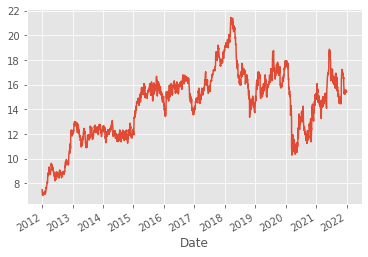

In [103]:
# Loading the dataset
#p = '10y'
#i = '1d'

df = yf.download(tickers='abev3.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [104]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.876644
High         0.882871
Low          0.876364
Close        0.878957
Adj Close    1.000000
Volume       0.235908
Name: Adj Close, dtype: float64

In [105]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,10.890463,10.980400,10.746562,10.872475,7.493662,119582
2012-01-03,10.892461,10.946424,10.654626,10.748561,7.408257,2099952
2012-01-04,10.716583,10.748561,10.316860,10.498734,7.236069,989684
2012-01-05,10.362828,10.390808,10.194944,10.290878,7.092808,1077745
2012-01-06,10.288879,10.430781,10.206936,10.264896,7.074901,451312
...,...,...,...,...,...,...
2021-12-23,15.400000,15.670000,15.340000,15.550000,15.550000,10634700
2021-12-27,15.550000,15.650000,15.480000,15.530000,15.530000,8437200
2021-12-28,15.540000,15.570000,15.400000,15.520000,15.520000,7701300


In [106]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df.shape

count    2.464000e+03
mean     1.491285e+07
std      1.446563e+07
min      1.900000e+03
25%      7.422070e+06
50%      1.245780e+07
75%      1.971638e+07
max      2.876952e+08
Name: Volume, dtype: float64


(2464, 6)

# Variáveis externas

In [107]:
def consulta_selic(ultimos):
  url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados/ultimos/{}?formato=json'.format(ultimos)
     #'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=01/01/2012&dataFinal=31/12/2021'
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [108]:
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Adj Close'] + df['High']).div(3).values
    return df.assign(Vwap=(tp * v).cumsum() / v.cumsum())

In [109]:
# Dollar Brasileiro
df_dollar = yf.download(tickers=['USDBRL=x'], start="2012-01-01", end="2021-12-31")
# SP500
df_sp500 = yf.download(tickers=['SPY'], start="2012-01-01", end="2021-12-31")
# Ibovespa
df_ibov = yf.download(tickers=['^BVSP'], start="2012-01-01", end="2021-12-31")
#Petroleo da China
df_ptr = yf.download(tickers=['PTR'], start="2012-01-01", end="2021-12-31")
#Petroleo Brasil
df_pbr = yf.download(tickers=['PBR'], start="2012-01-01", end="2021-12-31")
#Dow Jones Industrial
df_dji = yf.download(tickers=['^DJI'], start="2012-01-01", end="2021-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [110]:
df_petr = yf.download(tickers='abev3.sa', start="2012-01-01", end="2021-12-31")
df_petr.drop(df_petr[df_petr['Volume']==0].index, inplace = True)
print(df_petr.shape)
#Calculando VWAP
df_petr = vwap(df_petr)

# #Concatenando variáveis
df_temp = df_petr.rename(columns={"Adj Close": "Adj_close"})

#Dollar
temp = df_dollar['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Usdbrl"})

#sp500
temp = df_sp500['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Sp500"})

# #Dow Jones Industrial
temp = df_dji['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Dji"})

# #ibov
temp = df_ibov['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Ibov"})

# #Petroleo
temp = df_pbr['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Pbr"})

# #Selic
# temp = df_selic['valor']
# df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
# df_temp = df_temp.rename(columns={"valor": "Selic"})

df_data = df_temp

df_data
print(df_data.shape)
df_data


[*********************100%***********************]  1 of 1 completed
(2464, 6)
(2464, 12)


,Open,High,Low,Close,Adj_close,Volume,Vwap,Usdbrl,Sp500,Dji,Ibov,Pbr
Date,,,,,,,,,,,,
2012-01-02,10.890463,10.980400,10.746562,10.872475,7.493662,119582,9.740208,1.8623,NaN,NaN,NaN,NaN
2012-01-03,10.892461,10.946424,10.654626,10.748561,7.408257,2099952,9.673564,1.8701,104.950836,12397.379883,59265.0,19.149206
2012-01-04,10.716583,10.748561,10.316860,10.498734,7.236069,989684,9.599633,1.8345,105.115448,12418.419922,59365.0,19.405899
2012-01-05,10.362828,10.390808,10.194944,10.290878,7.092807,1077745,9.505748,1.8184,105.395309,12415.700195,58546.0,19.149206
2012-01-06,10.288879,10.430781,10.206936,10.264896,7.074900,451312,9.480202,1.8430,105.123680,12359.919922,58600.0,18.841177
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,15.400000,15.670000,15.340000,15.550000,15.550000,10634700,16.342152,5.6530,469.142548,35950.558594,104891.0,10.790000
2021-12-27,15.550000,15.650000,15.480000,15.530000,15.530000,8437200,16.341971,5.6711,475.781921,36302.378906,105531.0,11.080000
2021-12-28,15.540000,15.570000,15.400000,15.520000,15.520000,7701300,16.341794,5.6241,475.393127,36398.210938,104864.0,11.100000


In [111]:
df_data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj_close     0
Volume        0
Vwap          0
Usdbrl        5
Sp500        60
Dji          60
Ibov          1
Pbr          60
dtype: int64

In [112]:
#Imputando dados baseado na média 20
df_data['Usdbrl'] = df_data['Usdbrl'].fillna(df_data['Usdbrl'].rolling(30,min_periods=1).mean())
df_data['Sp500'] = df_data['Sp500'].fillna(df_data['Sp500'].rolling(30,min_periods=1).mean())
df_data['Dji'] = df_data['Dji'].fillna(df_data['Dji'].rolling(30,min_periods=1).mean())
df_data['Ibov'] = df_data['Ibov'].fillna(df_data['Ibov'].rolling(30,min_periods=1).mean())
df_data['Pbr'] = df_data['Pbr'].fillna(df_data['Pbr'].rolling(30,min_periods=1).mean())
#df_data['Selic'] = df_data['Selic'].fillna(df_data['Selic'].rolling(30,min_periods=1).mean())

print(df_data.isnull().sum())
df_data.dropna(inplace=True)
print(df_data.isnull().sum())
df = df_data

Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       0
Sp500        1
Dji          1
Ibov         1
Pbr          1
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       0
Sp500        0
Dji          0
Ibov         0
Pbr          0
dtype: int64


In [113]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [114]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [115]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    
    X_train,Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [116]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [117]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [118]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [119]:
# Extracting the series
#features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Vwap', 'Usdbrl', 'Sp500', 'Ibov', 'Dji', 'Pbr']
#features = ['Close', 'Low', 'High', 'Usdbrl', 'Pbr']
features = ['Adj_close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2463, 4)
            Adj_close   Open    Low   High
Date                                      
2021-12-23      15.55  15.40  15.34  15.67
2021-12-27      15.53  15.55  15.48  15.65
2021-12-28      15.52  15.54  15.40  15.57
2021-12-29      15.45  15.55  15.34  15.56
2021-12-30      15.42  15.58  15.39  15.59


In [120]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1863, 4) (300, 4) (300, 4)


In [121]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1863, 4) (300, 4) (300, 4)


In [131]:
timesteps = 30
hl = [20,15]
lr = 1e-3
batch_size = 64
num_epochs = 60

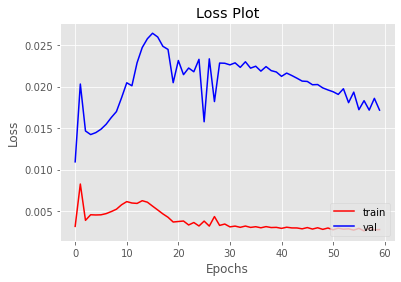

In [132]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.03413597140502736
MSE = 0.0018925735842541642
RMSE = 0.043503719200249584
R2-Score = 0.7170421793764732


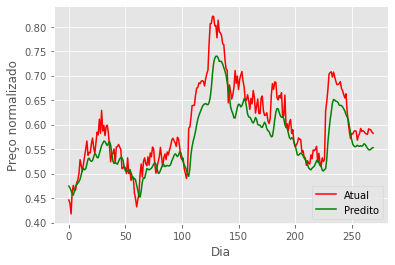

In [134]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [135]:
# Save a model
model.save('RNN-M_30_[50,45]_1e-3_32.h5')
del model  #Deletes the model
# Load a model
model = load_model('RNN-M_30_[50,45]_1e-3_32.h5')

## Cross Validation

In [136]:
timesteps = 30
hl = [20,15]
lr = 1e-3
batch_size = 64
num_epochs = 30

In [137]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2463, 4)
            Adj_close   Open    Low   High
Date                                      
2021-12-23      15.55  15.40  15.34  15.67
2021-12-27      15.53  15.55  15.48  15.65
2021-12-28      15.52  15.54  15.40  15.57
2021-12-29      15.45  15.55  15.34  15.56
2021-12-30      15.42  15.58  15.39  15.59


In [138]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.02656736, 0.04927193, 0.03836588, 0.04847382],
       [0.01462169, 0.03688362, 0.01408193, 0.03464414],
       [0.0046828 , 0.01196612, 0.00531669, 0.00963887],
       ...,
       [0.58932493, 0.37663131, 0.37953862, 0.37164047],
       [0.58446859, 0.3773357 , 0.37522491, 0.37094157],
       [0.58238734, 0.3794488 , 0.37881972, 0.37303841]])

### Split I

In [139]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.019219155063445615
MSE = 0.0005411017722821904
RMSE = 0.023261594362429038
R-Squared Score = 0.7579829066253357


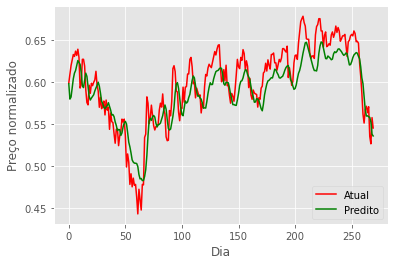

In [140]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split1.h5")

### Split II

Split 2
MAE = 0.015340686347071811
MSE = 0.00039617777300549306
RMSE = 0.019904214955769873
R-Squared Score = 0.9646171033182056


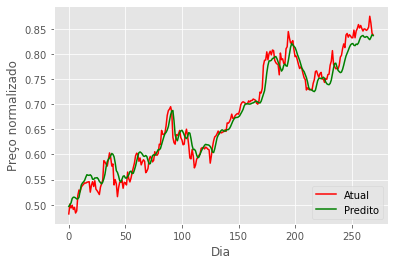

In [141]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split2.h5")

### Split III

Split 3
MAE = 0.02590232389556764
MSE = 0.00102706646880839
RMSE = 0.03204787775826022
R-Squared Score = 0.9372096419913297


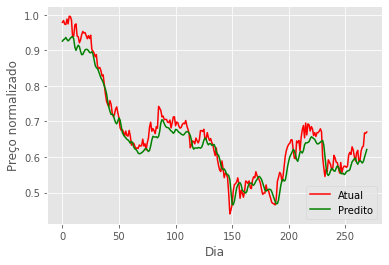

In [142]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split3.h5")

### Split IV

Split 4
MAE = 0.04126564688221956
MSE = 0.002318686003406609
RMSE = 0.04815273619854441
R-Squared Score = 0.9241734374132375


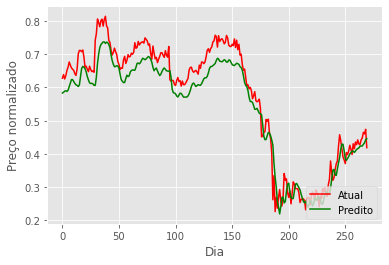

In [143]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split4.h5")

### Split V

Split 5
MAE = 0.05965147356216515
MSE = 0.004732252898600778
RMSE = 0.06879137226862667
R-Squared Score = 0.6931868112893991


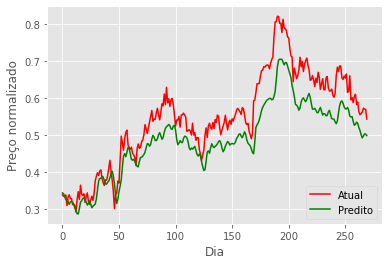

In [144]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split5.h5")

In [145]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.032275857150093956
Avg. MSE = 0.001803056983220692
Avg. RMSE = 0.038431559108726046
Avg. R2-score = 0.8554339801275015


In [146]:
CV_results.to_csv('RNN-M ABEV3.csv')
# train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
# val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')